In [18]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf

from ssd import SSD512, MultiboxLoss, BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

In [19]:
voc_classes = ['m1','m2','m3','m4','m5','m6','m7','m8','m9',
               'p1','p2','p3','p4','p5','p6','p7','p8','p9',
               's1','s2','s3','s4','s5','s6','s7','s8','s9',
               'e','s','w','n','haku','hatsu','chun']
NUM_CLASSES = len(voc_classes) + 1

In [20]:
input_shape=(512, 512, 3)
model = SSD512(input_shape, num_classes=NUM_CLASSES)
model.load_weights('checkpoints/weights.00-3.24.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

# 分類したい画像の選択

In [21]:
inputs = []
images = []

img_path = './test_image/m2_p1_s1_m1.jpg'
img = image.load_img(img_path, target_size=(512, 512))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())

img_path = './test_image/2017-12-23T19:41:37:982652.jpg'
img = image.load_img(img_path, target_size=(512, 512))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())

img_path = './train_images_512_512_1000/2018-02-02T00:59:38:576969.jpg'
img = image.load_img(img_path, target_size=(512, 512))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())

inputs = preprocess_input(np.array(inputs))

In [22]:
preds = model.predict(inputs, batch_size=1, verbose=1)

3/3 [==============================] - 12s    


In [23]:
results = bbox_util.detection_out(preds)

In [24]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds)

CPU times: user 24.5 s, sys: 464 ms, total: 25 s
Wall time: 13.3 s


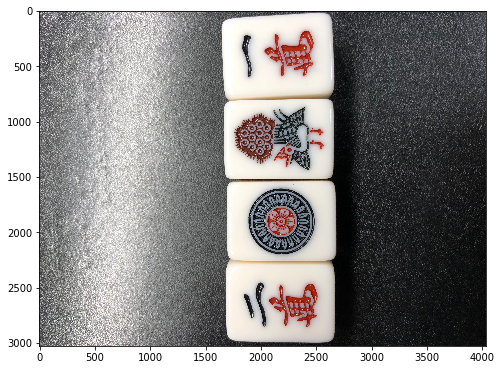

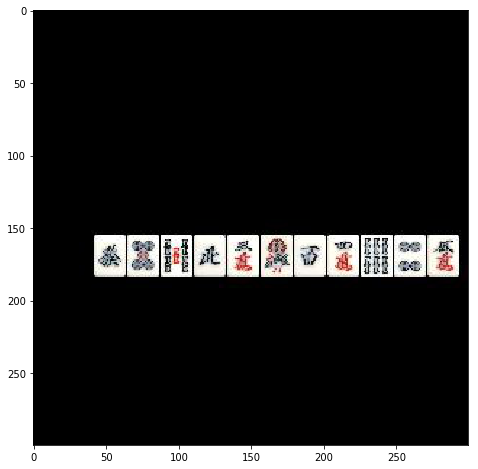

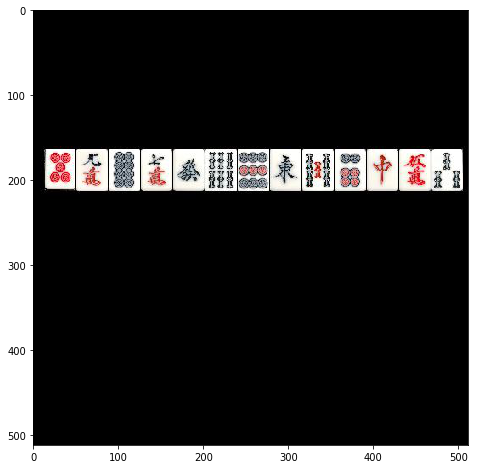

In [25]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, NUM_CLASSES)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()